In [1]:
# Load trained latent prediction models, and generate rate-accuracy curve for RFW.
import torch
import torchvision.models as models
import torch.nn as nn
from tqdm import tqdm
import torch.nn.functional as F
import matplotlib.pyplot as plt
from pathlib import Path
import json

# project modules
from predict import perform_inference
import rfw_loader 
from datasets.rfw_latent import RFW_raw, RFW_latent, create_dataloaders
from train import train, write_model, save_model
from detection_models import HierarchicalVAE_ResNet
from latent_utils import get_latent
from RFW_utils import save_race_based_predictions_latent, save_race_based_predictions, load_predictions, get_classification_report

# neural compression model
import sys
sys.path.append('/home/tianqiu/NeuralCompression/lossy-vae')
from lvae import get_model
from lvae.models.qresvae import zoo

In [2]:
DECODED_IMAGE_ROOT='/media/global_data/fair_neural_compression_data/decoded_rfw'
output_dims = {
    'skin_type': 6,
    'eye_type': 2,
    'nose_type': 2,
    'lip_type': 2,
    'hair_type': 4,
    'hair_color': 5
}
categories = list(output_dims.keys())
races = ['Indian', 'Asian', 'African', 'Caucasian']

In [3]:
data_rates=[12]
pseudo_decoder_model_dict= {
    1:'../models/.pth',
    3:'../models/.pth',
    6:'../models/.pth',
    9:'../models/.pth',
    12:'../models/latent_RFW_pseudo_decoder_lr1e-3_epoch_100.pth',
}

In [4]:
image_model_dict= {
    1:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=1.pth',
    3:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=3.pth',
    6:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=6.pth',
    9:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=9.pth',
    12:'../models/converged_models/best_RFW_resnet18_lambda=64_data_rate=12.pth',
}

In [5]:
DEVICE = 0
device = torch.device(f'cuda:{DEVICE}' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda', index=0)

In [6]:
BATCH_SIZE=512

RFW_IMAGES_DIR =  "/media/global_data/fair_neural_compression_data/datasets/RFW/data_64"
RFW_LABELS_DIR = "/media/global_data/fair_neural_compression_data/datasets/RFW/clean_metadata/numerical_labels.csv"
image_ds = RFW_raw(RFW_IMAGES_DIR, RFW_LABELS_DIR)
_, val_loader, test_loader = create_dataloaders(
    image_ds,
    BATCH_SIZE, 
)

In [7]:
# save all predictions and labels
load_results = False
for n_keep in data_rates:
    model_path = pseudo_decoder_model_dict[n_keep]
    model_name = Path(model_path).stem # keep stem, remove parents and ext.
    model = torch.load(model_path).to(device)
    if not load_results:
        all_predictions, all_labels = save_race_based_predictions( 
                                                        model,
                                                        model_name,
                                                        test_loader, 
                                                        device, 
                                                        f'../results/latent_RFW_test_pseudo_decoder/predictions/{n_keep}',
                                                        save_labels=True
                                                    )
    else:
        # directly load existing results
        all_predictions, all_labels = load_predictions(model_name, f'../results/latent_RFW_test_pseudo_decoder/predictions/{n_keep}')

prediction_save_dir: ../results/latent_RFW_test_pseudo_decoder/predictions/12


Getting Predictions: 100%|██████████| 12/12 [00:04<00:00,  2.92batch/s]


In [8]:
pseudo_decoder_performance_metrics = []
for n_keep in data_rates:
    model_path = pseudo_decoder_model_dict[n_keep]
    model_name = Path(model_path).stem # keep stem, remove parents and ext.
    performance = get_classification_report(
            races,
            categories,
            f'../results/latent_RFW_test_pseudo_decoder/predictions/{n_keep}',
            model_name
        )
    pseudo_decoder_performance_metrics.append(performance)

In [9]:
image_performance_metrics = []
for n_keep in data_rates:
    model_path = image_model_dict[n_keep]
    model_name = Path(model_path).stem # keep stem, remove parents and ext.
    performance = get_classification_report(
            races,
            categories,
            f'../results/RFW_test/predictions/{n_keep}',
            model_name
        )
    image_performance_metrics.append(performance)

In [10]:
bpps = []
for data_rate in data_rates:
    json_path = f'{DECODED_IMAGE_ROOT}/progressive_64x64/qres17m/q_64/{data_rate}/stats.json'
    with open(json_path, 'r') as json_file:
        data_dict = json.load(json_file)
        bpps.append(data_dict['results']['bpp'])

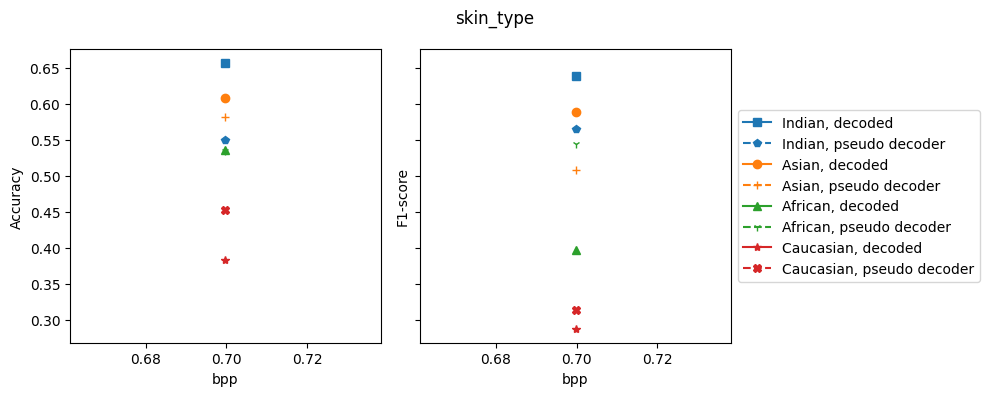

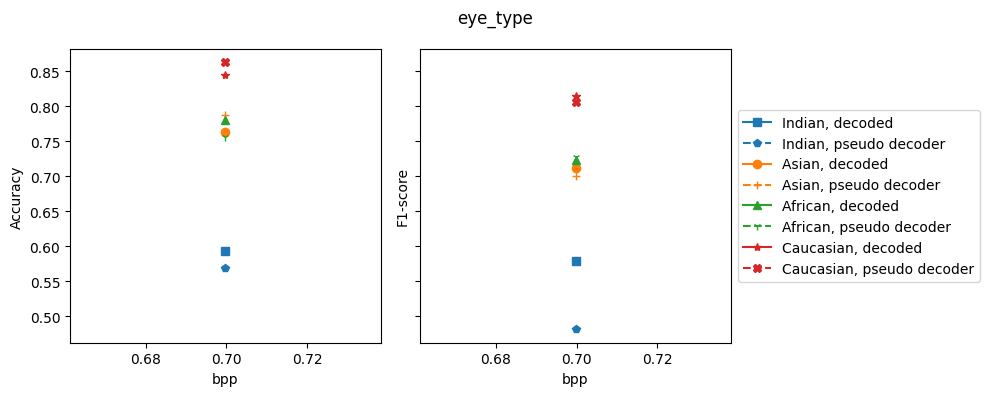

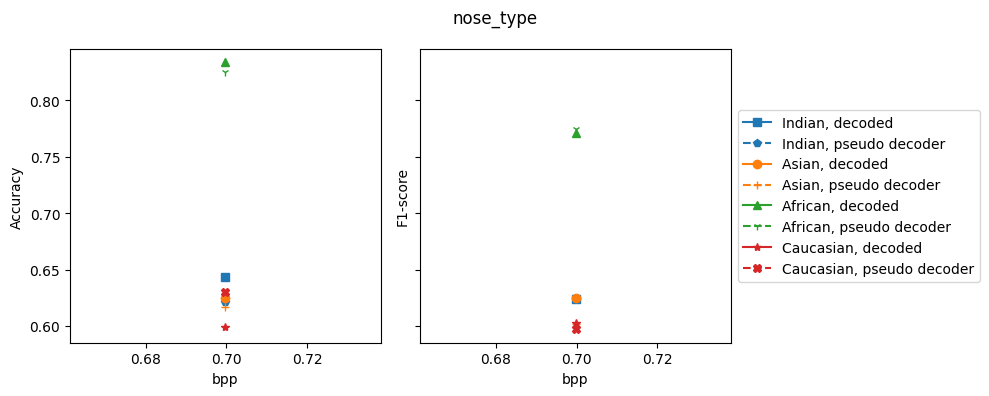

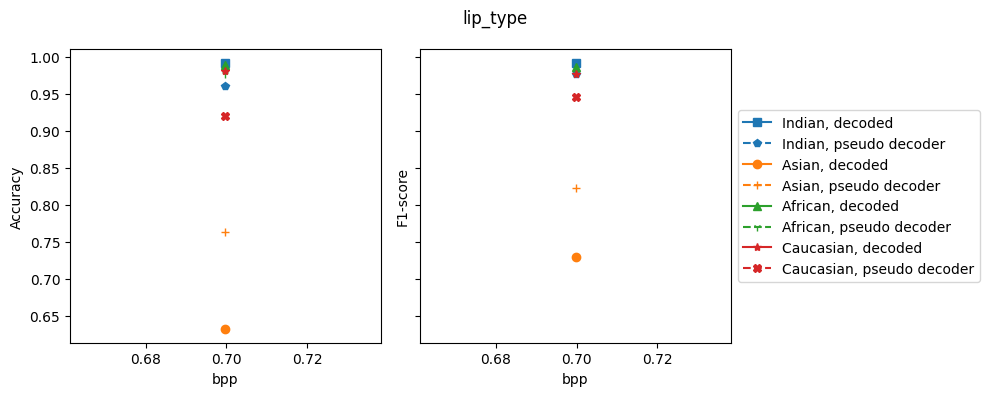

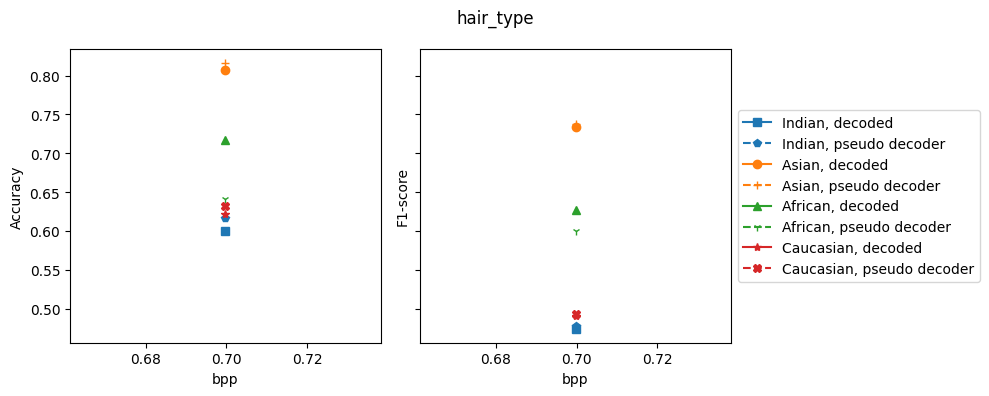

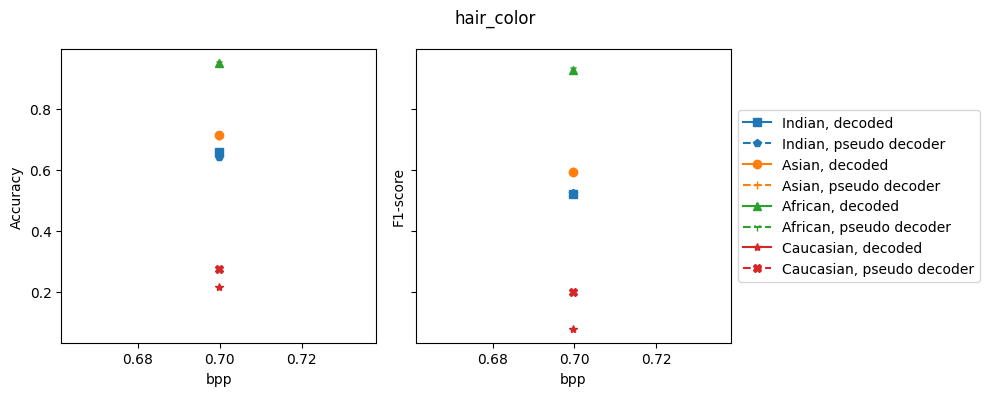

In [11]:
all_metrics_plot_path="../results/latent_RFW_test_pseudo_decoder/plots"
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red']
race_markers_image = ['s', 'o', '^', '*']
race_markers_pseudo = ['p', '+', '1', 'X']

# fig, axes = plt.subplots(6, 2, figsize=(10, 20), sharex=True, sharey=True)

for i, category in enumerate(categories):
    fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for j, race in enumerate(races):
        latent_race_accuracies, latent_race_f1_scores = [], []
        image_race_accuracies, image_race_f1_scores = [], []

        for k, data_rate in enumerate(data_rates):
            # latent plot data
            latent_race_accuracies.append(pseudo_decoder_performance_metrics[k]['acc'][category][race])
            latent_race_f1_scores.append(pseudo_decoder_performance_metrics[k]['f1'][category][race])
            # image plot data
            image_race_accuracies.append(image_performance_metrics[k]['acc'][category][race])
            image_race_f1_scores.append(image_performance_metrics[k]['f1'][category][race])
        axes[0].plot(bpps, image_race_accuracies, marker=race_markers_image[j], color=colors[j], label=race+', decoded')
        axes[1].plot(bpps, image_race_f1_scores, marker=race_markers_image[j], color=colors[j], label=race+', decoded')

        axes[0].plot(bpps, latent_race_accuracies, marker=race_markers_pseudo[j], color=colors[j], linestyle='dashed', label=race+', pseudo decoder')
        axes[1].plot(bpps, latent_race_f1_scores, marker=race_markers_pseudo[j], color=colors[j], linestyle='dashed', label=race+', pseudo decoder')

        axes[1].set_xlabel('bpp')
        axes[0].set_xlabel('bpp')
        axes[0].set_ylabel('Accuracy')
        axes[1].set_ylabel('F1-score')
        
        # axes[0].legend()
        axes[1].legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.suptitle(category)
    plt.tight_layout()
    # plt.savefig(f'{all_metrics_plot_path}/latent_vs_image_prediction_{category}.png', dpi=200)
    plt.show()

In [ ]:
# bar plot on one rate

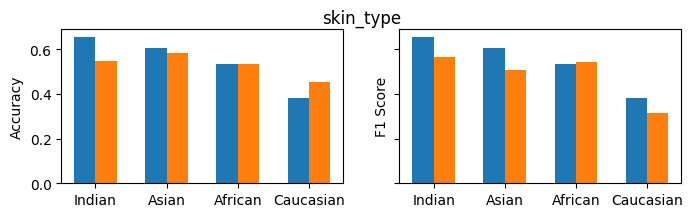

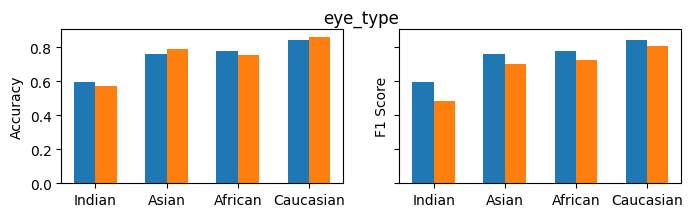

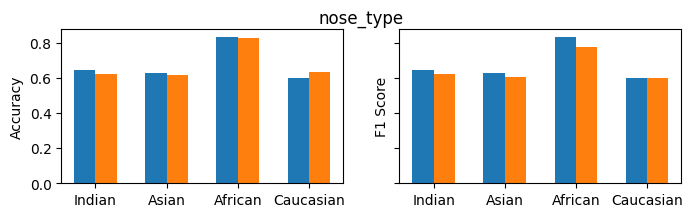

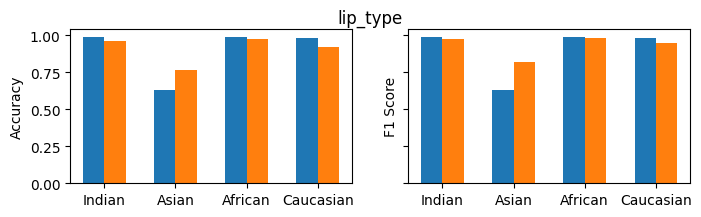

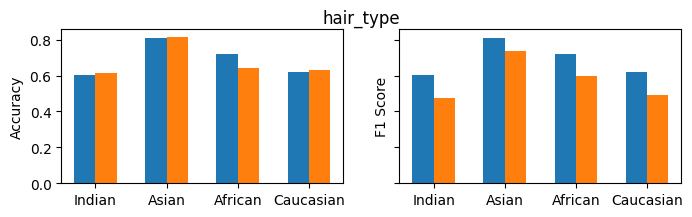

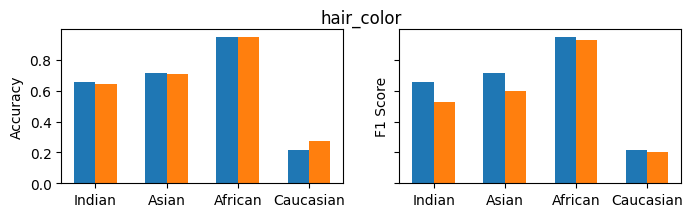

In [34]:
import numpy as np
ind = np.arange(4)
width = 0.3  
for i, category in enumerate(categories):
    fig, axes = plt.subplots(1, 2, figsize=(8, 2), sharey=True)
    axes[0].bar(ind, [image_performance_metrics[k]['acc'][category][race] for race in races], width)
    axes[0].bar(ind+width, [pseudo_decoder_performance_metrics[k]['acc'][category][race] for race in races], width)
    axes[0].set_ylabel('Accuracy')
    axes[0].set_xticks(ind + width / 2, races)
    axes[1].bar(ind, [image_performance_metrics[k]['acc'][category][race] for race in races], width, label='Blue bar label')
    axes[1].bar(ind+width, [pseudo_decoder_performance_metrics[k]['f1'][category][race] for race in races], width)
    axes[1].set_ylabel('F1 Score')
    axes[1].set_xticks(ind + width / 2, races)
    fig.suptitle(category)

In [21]:
pseudo_decoder_performance_metrics[k].keys()

dict_keys(['acc', 'f1'])